## Load Datasets

In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 3.8 MB 7.5 MB/s 
     |████████████████████████████████| 67 kB 2.3 MB/s 
     |████████████████████████████████| 6.5 MB 40.4 MB/s 
     |████████████████████████████████| 596 kB 54.7 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
     |████████████████████████████████| 312 kB 8.6 MB/s 
     |████████████████████████████████| 134 kB 52.1 MB/s 
     |████████████████████████████████| 212 kB 53.5 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 127 kB 71.8 MB/s 
     |████████████████████████████████| 271 kB 60.4 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 78.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is

In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Preprocess Data

In [5]:
from transformers import AutoTokenizer

model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

Downloading:   0%|          | 0.00/291 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/768 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [6]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device))

Downloading:   0%|          | 0.00/255M [00:00<?, ?B/s]

In [8]:
emotions_encoded["train"].features

{'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'text': Value(dtype='string', id=None)}

## Evaluation

In [9]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [11]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=8,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=False,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  save_strategy="no",
                                  disable_tqdm=False)

In [12]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])

In [13]:
results = trainer.evaluate()
results

The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64


{'eval_accuracy': 0.934,
 'eval_f1': 0.9341761984075759,
 'eval_loss': 0.15151549875736237,
 'eval_runtime': 223.4414,
 'eval_samples_per_second': 8.951,
 'eval_steps_per_second': 0.143}

In [14]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 64


{'test_accuracy': 0.934,
 'test_f1': 0.9341761984075759,
 'test_loss': 0.15151549875736237,
 'test_runtime': 204.5601,
 'test_samples_per_second': 9.777,
 'test_steps_per_second': 0.156}

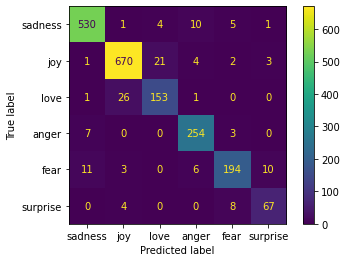

In [25]:
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay , confusion_matrix
y_valid = np.array(emotions_encoded["validation"]["label"])
y_preds = np.argmax(preds_output.predictions, axis=1)
labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_preds, y_valid )
ConfusionMatrixDisplay(cm , display_labels = labels).plot()

In [24]:
set(y_preds)

{0, 1, 2, 3, 4, 5}

## Inference

In [ ]:
from transformers import pipeline
classifier = pipeline("text-classification",model='bhadresh-savani/distilbert-base-uncased-emotion', return_all_scores=True)
prediction = classifier("I love using transformers. The best part is wide range of support and its easy to use", )



In [28]:
print(prediction)

[[{'label': 'sadness', 'score': 0.000679271062836051}, {'label': 'joy', 'score': 0.9959298968315125}, {'label': 'love', 'score': 0.0009452458471059799}, {'label': 'anger', 'score': 0.0018055220134556293}, {'label': 'fear', 'score': 0.0004111042362637818}, {'label': 'surprise', 'score': 0.00022885717044118792}]]
